# ASMSA: Train AAE model with the tuned hyperparameters

**Previous steps**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files
- [tune.ipynb](tune.ipynb): Perform initial hyperparameter tuning for this molecule

**Next step**
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [1]:
threads = 2

import os
os.environ['OMP_NUM_THREADS']=str(threads)
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2025-09-01 14:28:25.728149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-01 14:28:25.744019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-01 14:28:25.748574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-01 14:28:25.760466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-01 14:28:26.543498: W tensorflow/compiler/tf2

In [2]:
from asmsa.tuning_analyzer import TuningAnalyzer
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa.visualizer as visualizer
import asmsa


from asmsa.plot_training import LiveTrainingPlot

2025-09-01 14:28:28.888190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1215 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:21:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in **prepare.ipynb**. 


In [3]:
exec(open('inputs.py').read())

## Load datasets
Load filtered trajectory datasets that were processed in **prepare.ipynb**. Trajectories are in internal coordinates format.

In [4]:
my_hps = {
    'activation' : 'gelu',
    'ae_neuron_number_seed' : 128,
    'disc_neuron_number_seed' : 32,
    'ae_number_of_layers' : 3,
    'disc_number_of_layers' : 2,
    'batch_size' : 64,
    'optimizer' : 'AdamW',
    'learning_rate' : 0.0002,
    'ae_loss_fn' : 'MeanSquaredError',
    'disc_loss_fn' : 'BinaryCrossentropy'
}

In [23]:
# Get best HP from latest tuning 
# e.g: "analysis/xxx-yyy/"
# ... or don't specify, by default use the last analysis

analyzer = TuningAnalyzer()
analyzer.get_best_hp(num_trials=3)

Analyzing tuning from: /home/jovyan/ASMSA_DE/analysis/09012025-124407/
Printing results of tuning: /home/jovyan/ASMSA_DE/analysis/09012025-124407/
-----(1)-----
Trial ID: 7f93d524776c9ee9619c9025415818abd8eeb4f1eae923e9333269d92d788316
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 3
batch_size: 64
optimizer: AdamW
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.22744952506044377
-----(2)-----
Trial ID: ca84e009ec45af0fb106b0eae48487799164fa50d6773b64cdc6c742577c8905
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 2
batch_size: 64
optimizer: AdamW
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.23052353867265835
-----(3)-----
Trial ID: 05b3d4a70f8c503c574c76699c770893e01ad71d05ea136babd0342d217f045d
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: AdamW
learning_rate: 0.0002


In [24]:
# Select HP to use by specifying trial_id
#  e.g: trial_id = '483883b929b3445bff6dee9759c4d50ee3a4ba7f0db22e665c49b5f942d9693b'
# ... or don't specify, by default use the trial with the lowest score
trial_id = '7f93d524776c9ee9619c9025415818abd8eeb4f1eae923e9333269d92d788316'

hps = None
for trial in analyzer.sorted_trials:
    if trial['trial_id'] == trial_id:
        hps = trial['hp']
    
if not hps:
    print(f'Could not find trial with specified ID, using one with the lowest score - {analyzer.sorted_trials[0]["trial_id"]}')
    hps = analyzer.sorted_trials[0]['hp']
    
print(hps)

{'activation': 'gelu', 'ae_number_of_layers': 2, 'disc_number_of_layers': 3, 'batch_size': 64, 'optimizer': 'AdamW', 'learning_rate': 0.0002, 'ae_loss_fn': 'MeanSquaredError', 'disc_loss_fn': 'BinaryCrossentropy'}


In [25]:
# load train dataset
X_train = tf.data.Dataset.load('datasets/intcoords/train')

# get batched version of dataset to feed to AAE model for training
X_train_batched = X_train.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for visualization purposes
X_train_np = np.stack(list(X_train))
X_train_np.shape

2025-09-01 14:40:16.603880: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(31064, 339)

In [26]:
# load test dataset
X_test = tf.data.Dataset.load('datasets/intcoords/test')

# get batched version of dataset to feed to AAE model for prediction
X_test_batched = X_test.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for testing purposes
X_test_np = np.stack(list(X_test))
X_test_np.shape

(6697, 339)

In [27]:
X_val = tf.data.Dataset.load('datasets/intcoords/validate').batch(hps['batch_size'],drop_remainder=True)
X_val_np = np.stack(list(X_val))
X_val_np.shape

(122, 64, 339)

In [36]:
# Pick best number of encoder and discriminator seeds from plots in tune.ipynb 
best_enc_seed=128
best_disc_seed=128 

## Train

### Distribution prior
Train with common prior distributions. See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions for all available distributions. It is ideal to use tuned Hyperparameters for training.

In [37]:
# Choose the prior p(z)

prior = tfp.distributions.Normal(loc=0, scale=1)
#prior = tfp.distributions.Uniform()

# ...or Build your custom prior
'''
tfd = tfp.distributions
means = tf.constant([[0.7, 0.0],[-0.7, 0.0],[0.0, 0.7] ], dtype=tf.float32)
scales = tf.constant([[0.15, 0.15],[0.15, 0.15],[0.15, 0.15]], dtype=tf.float32)
components = tfd.MultivariateNormalDiag(loc=means, scale_diag=scales)
mix = tfd.Categorical(probs=[0.3, 0.3, 0.3])

prior = tfd.MixtureSameFamily(mixture_distribution=mix, components_distribution=components)
'''


'\ntfd = tfp.distributions\nmeans = tf.constant([[0.7, 0.0],[-0.7, 0.0],[0.0, 0.7] ], dtype=tf.float32)\nscales = tf.constant([[0.15, 0.15],[0.15, 0.15],[0.15, 0.15]], dtype=tf.float32)\ncomponents = tfd.MultivariateNormalDiag(loc=means, scale_diag=scales)\nmix = tfd.Categorical(probs=[0.3, 0.3, 0.3])\n\nprior = tfd.MixtureSameFamily(mixture_distribution=mix, components_distribution=components)\n'

In [38]:
# Prepare model using the best hyperparameters from analysis

test = asmsa.AAEModel((X_train_np.shape[1],),
                       prior=prior,
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       with_density=False
                      )
test.compile()

In [39]:
test.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 339)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_0 (Dense)                   │ (None, 128)            │        43,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_1 (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_2 (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_2 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_out (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_3 (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_3 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_1 (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_0 (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_out (Dense)                 │ (None, 339)            │        43,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 339)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,973 (429.58 KB)

 Trainable params: 109,077 (426.08 KB)

 Non-trainable params: 896 (3.50 KB)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_0 (Dense)                  │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_0 (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_1 (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_2 (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_3 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_3 (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_out (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tabulate import tabulate  # se non hai tabulate, puoi fare pip install tabulate

for layer in test.layers:
    print(f"\n== {layer.name} ==")
    if hasattr(layer, "layers"):  # significa che contiene sotto-layer
        for sublayer in layer.layers:
            act = getattr(sublayer, "activation", None)
            act_name = act.__name__ if act is not None else "—"
            print(f"{sublayer.name:20s} | activation={act_name:10s} | params={sublayer.count_params()}")
    else:
        act = getattr(layer, "activation", None)
        act_name = act.__name__ if act is not None else "—"
        print(f"{layer.name:20s} | activation={act_name:10s} | params={layer.count_params()}")




== functional_8 ==
input_layer_4        | activation=—          | params=0
enc_0                | activation=gelu       | params=43520
enc_bn_0             | activation=—          | params=512
enc_1                | activation=gelu       | params=8256
enc_bn_1             | activation=—          | params=256
enc_2                | activation=gelu       | params=2080
enc_bn_2             | activation=—          | params=128
enc_out              | activation=linear     | params=66
dec_3                | activation=gelu       | params=96
dec_bn_3             | activation=—          | params=128
dec_1                | activation=gelu       | params=2112
dec_bn_1             | activation=—          | params=256
dec_0                | activation=gelu       | params=8320
dec_bn_0             | activation=—          | params=512
dec_out              | activation=linear     | params=43731
reshape_2            | activation=—          | params=0

== functional_9 ==
input_layer_4        | activat

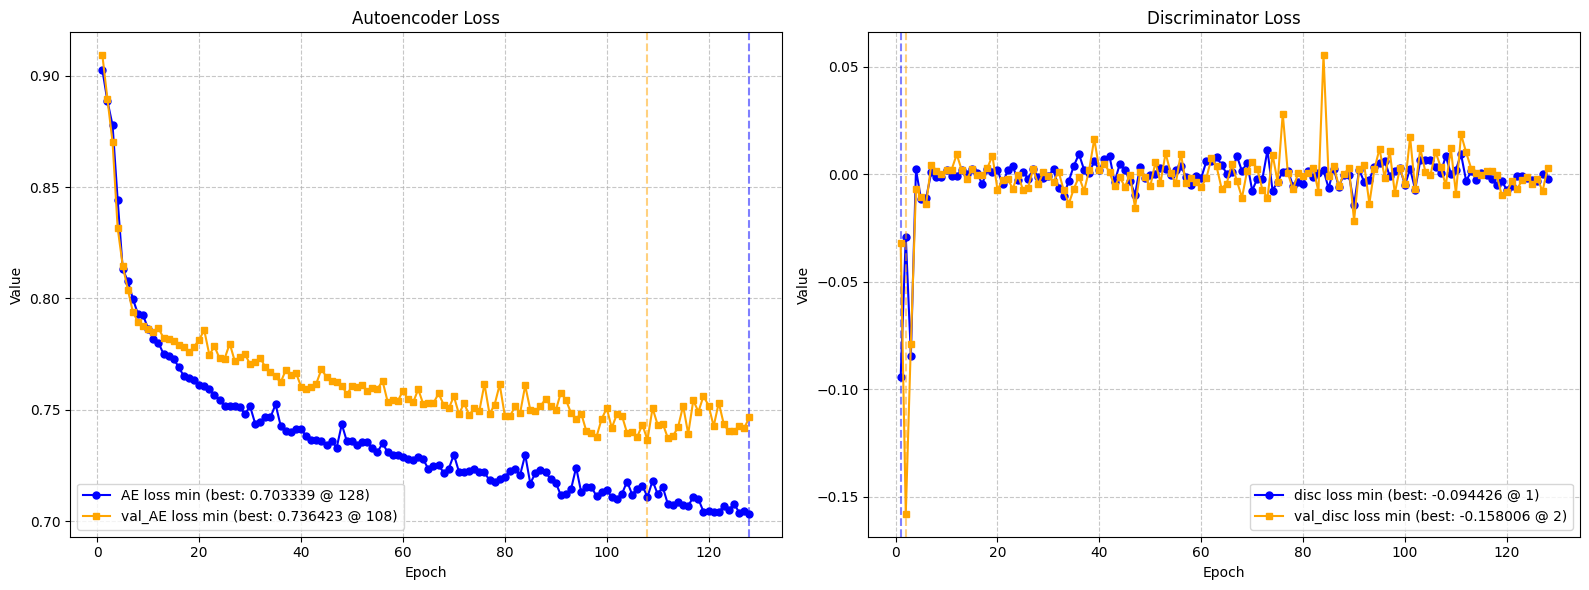

485/485 - 2s - 4ms/step - AE loss min: 0.7033 - disc loss min: -2.1282e-03 - val_AE loss min: 0.7467 - val_disc loss min: 0.0030
Epoch 128: early stopping
Restoring model weights from the end of the best epoch: 108.


In [41]:
metric_groups = {
    "Autoencoder Loss": ["AE loss min", "val_AE loss min"],
    "Discriminator Loss": ["disc loss min", "val_disc loss min"],
}

# train it (can be repeated several times to add more epochs)
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_AE loss min",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

test.fit(X_train_batched, 
          epochs=1000,
          verbose=2, 
          validation_data=X_val,
          callbacks=[
              early_stop_cb,
              LiveTrainingPlot(metric_groups=metric_groups, freq=1),
              #visualizer.VisualizeCallback(test,freq=10,inputs=X_train_np[15000:25000],figsize=(12,3)) 
          ])

#Turn on the visualizer if you would like to see the latent space evolution every "freq" epochs. We advice to turn off the LiveTrainingPlot to avoid crowded output 

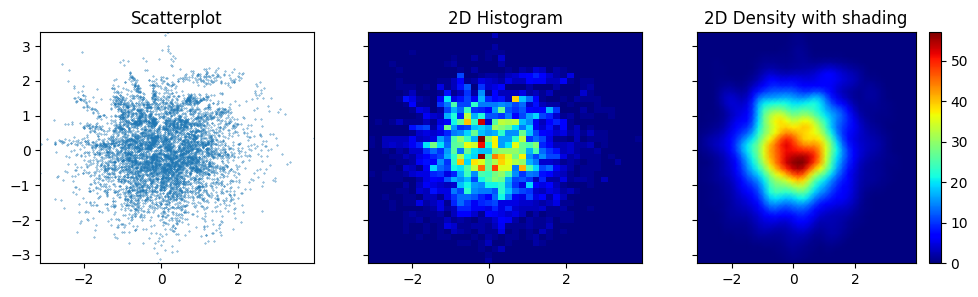

In [42]:
# final visualization, pick a slice of the input data for demo purposes
#visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np[15000:20000]).numpy())
# on test data
visualizer.Visualizer(figsize=(12,3)).make_visualization(test.call_enc(X_test_np).numpy())

In [43]:
# load testing trajectory for further visualizations and computations
tr = md.load('../DE-Shaw/x_test.xtc',top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like AlanineDipeptide
#idx=tr[0].top.select("element != H") 

tr.superpose(tr[0],atom_indices=idx)
geom = np.moveaxis(tr.xyz ,0,-1)
geom.shape

(144, 3, 6697)

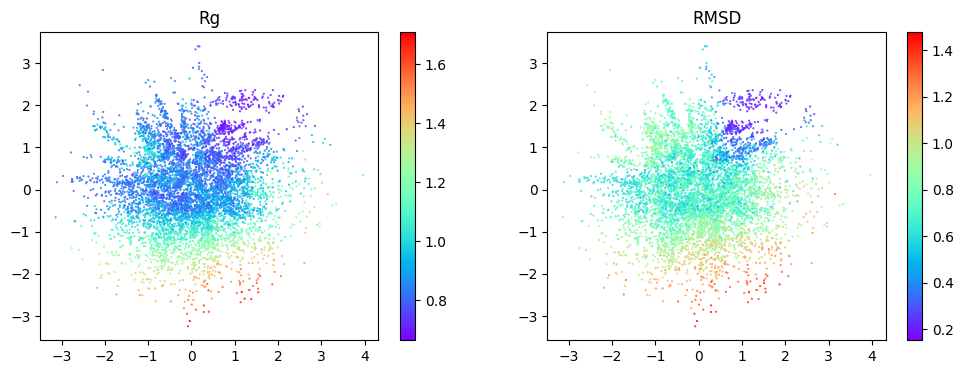

In [45]:
# Rgyr and rmsd color coded in low dim (rough view), compute any other properties according to your needs

lows = test.call_enc(X_test_np).numpy()
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

### Image prior

Use Image as a prior distribution. Again use tuned Hyperparameters for better training performance.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1I2WP92MMWS5s5vin_4cvmruuV-1W77Hl", "mushroom_bw.png")

In [ ]:
mmush = asmsa.AAEModel((X_train_np.shape[1],),
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       prior='mushroom_bw.png'
                      )
mmush.compile()

In [ ]:
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_val_AE loss min",
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [ ]:
mmush.fit(X_train_batched, # X_train_dens, # X_train_batched,
          epochs=1000,
          verbose=2, 
          validation_data=X_val,
          callbacks=[
              early_stop_cb,
              LiveTrainingPlot(metric_groups=metric_groups, freq=1),
              #visualizer.VisualizeCallback(testm,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])
#Turn on the visualizer if you would like to see the latent space evolution every "freq" epochs. We advice to turn off the LiveTrainingPlot to avoid crowded output 

In [ ]:
# Rgyr and rmsd color coded in low dim (rough view), compute any other properties according to your needs

step=4
tr2 = tr[::step]
lows = mmush.call_enc(X_test_np[::step]).numpy()
rg = md.compute_rg(tr2)
base = md.load(conf)
rmsd = md.rmsd(tr2,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

## Save the encoder and decoder models

In [ ]:
import tf2onnx
import onnx2torch
import tempfile

def _convert_to_onnx(model, destination_path):
    input_tensor = model.layers[0]._input_tensor
    input_signature = tf.TensorSpec(
        name=input_tensor.name, shape=input_tensor.shape, dtype=input_tensor.dtype
    )
    output_name = model.layers[-1].name

    @tf.function(input_signature=[input_signature])
    def _wrapped_model(input_data):
        return {output_name: model(input_data)}

    tf2onnx.convert.from_function(
        _wrapped_model, input_signature=[input_signature], output_path=destination_path
    )

In [ ]:
model = test

In [ ]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.enc,onnx.name)
    torch_enc = onnx2torch.convert(onnx.name)

example_input = torch.randn([X_train_np.shape[1]])
traced_script_module = torch.jit.trace(torch_enc, example_input)

traced_script_module.save('encoder-unif.pt')

In [ ]:
lenc = torch.jit.load('encoder-unif.pt')
example_input = np.random.rand(10000,X_train_np.shape[1])
rtf = model.enc(example_input)
rpt = lenc(torch.tensor(example_input,dtype=torch.float32))

In [ ]:
maxerr = np.max(np.abs(rtf - rpt.detach().numpy()))
maxerr

In [ ]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.dec,onnx.name)
    torch_dec = onnx2torch.convert(onnx.name)

example_input = torch.randn([2])
traced_script_module = torch.jit.trace(torch_dec, example_input)

traced_script_module.save('decoder-unif.pt')

In [ ]:
ldec = torch.jit.load('decoder-unif.pt')
example_input = np.random.rand(10000,2)
rtf = model.dec(example_input)
rpt = ldec(torch.tensor(example_input,dtype=torch.float32))

In [ ]:
err = np.abs(rtf - rpt.detach().numpy())
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32).reshape(1,1,-1)
rerr = err/np.abs(train_mean)
np.max(err),np.max(rerr)

## Final visualization

In [ ]:
test_geom = np.moveaxis(np.stack(list(tf.data.Dataset.load('datasets/geoms/test'))),2,0)
test_geom.shape

In [ ]:
tr = md.load(traj, top=conf)
tr.xyz.shape

In [ ]:
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32)
train_scale = np.loadtxt('datasets/intcoords/scale.txt',dtype=np.float32)

In [ ]:
mol_model = torch.jit.load('features.pt')
torch_encoder = torch.jit.load('encoder-unif.pt')

In [ ]:
class CompleteModel(torch.nn.Module):
    def __init__(self, mol_model, torch_encoder, train_mean, train_scale):
        super(CompleteModel, self).__init__()
        self.mol_model = mol_model
        self.torch_encoder = torch_encoder
        self.train_mean = torch.from_numpy(np.reshape(train_mean, (-1, 1)))
        self.train_scale = torch.from_numpy(np.reshape(train_scale, (-1, 1)))

    def forward(self, x):
        mol_output = self.mol_model(x.moveaxis(0,-1))
        normalized = (mol_output - self.train_mean) / self.train_scale
        return self.torch_encoder(normalized.T)

complete_model = CompleteModel(mol_model, torch_encoder, train_mean, train_scale)

example_input = torch.randn([1,test_geom.shape[1], test_geom.shape[2]])
traced_script_module = torch.jit.trace(complete_model, example_input)

model_file_name = "model.pt"
traced_script_module.save(model_file_name)

In [ ]:
m = torch.jit.load('model.pt')
lows = m(torch.tensor(tr.xyz)).numpy()
np.savetxt("lows.txt", lows)
lows.shape

In [ ]:
lows = np.loadtxt("lows.txt")
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=pot[:,1],cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("??")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap,s=1)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.savefig("xxx.png")


### Other Properties
* Color the latent space above with the variables calculated in this section to explore the computed properties in the low dimentinal space

#### Alpha elics
* **Traj** must be the tranining .xtc and .pdb

In [ ]:
traj = md.load_xtc("xxx.xtc", top="xxx.pdb")

dssp = md.compute_dssp(traj, simplified=True) 
alpha_content_per_frame = np.mean(dssp == 'H', axis=1)
average_alpha_helix_content = np.mean(alpha_content_per_frame)

print(f"Avarage alpha elics content: {average_alpha_helix_content:.3f}")

#### Contact pairs
* **x**: residue number.
* **y**:  Ca, Cb or whatever belonging with X, the user wish to compute. 

In [ ]:
atom_indices = (traj.topology.select("resid x and name y")[0],  
                traj.topology.select("resid x and name y")[0])

distances = md.compute_distances(traj, [atom_indices])  

In [ ]:
print(f'pair: {pairs[94]} \
distance: {distances[:, 94]}')

#### Angles
* **x**: same as above.
* **y**:  same as above

In [ ]:
atom_indices = traj.topology.select("resid x and name y")[0], \
               traj.topology.select("resid x and name y")[0], \
               traj.topology.select("resid x and name y")[0]

# Radiants
angles = md.compute_angles(traj, [atom_indices])  

# Degree
angles_deg = np.rad2deg(angles[:, 0])

#### dihedrals
* **x**: same as above.
* **y**:  same as above

In [ ]:
atom1 = traj.topology.select("resid x and name y")[0]
atom2 = traj.topology.select("resid x and name y")[0]
atom3 = traj.topology.select("resid x and name y")[0]
atom4 = traj.topology.select("resid x and name y")[0]

# Radiants
dihedrals = md.compute_dihedrals(traj, [[atom1, atom2, atom3, atom4]])
# Degree
dihedrals_deg = np.rad2deg(dihedrals[:, 0])  